In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
ae_loss = 'emd'

save_synthetic_samples = True
save_model = True
saver_step = 10

class_name = raw_input('Give me the class type: ').lower()
ae_id = raw_input('Give me the AE/experiment ID: ').lower()
cmp_type = raw_input('Comparison Type ("best" epoch vs. "max_min" epoch): ').lower()

syn_id = shape_net_category_to_synth_id()[class_name]

experiment_name = '_'.join(['nb_wgan_gp_ae', ae_id, ae_loss, class_name, str(n_pc_samples), cmp_type, 'epoch'])

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds'

train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/gan/nb_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir);

Give me the class type: chair
Give me the AE/experiment ID: 11
Comparison Type (best epoch vs. max_min epoch): best_epoch


In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [6]:
ae_help = relevant_class(ae_loss)

In [7]:
# Load Auto-Encoder
ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
bneck = ae.bottleneck_size
assert(ae_help.experiment_id_to_bneck[int(ae_id)] == bneck) 

if cmp_type.startswith('best'):
    load_epoch, _ = ae_help.best_epochs[bneck]
    print load_epoch
elif cmp_type.startswith('max'):
    load_epoch, _ = ae_help.max_min_epochs[bneck]
else:
    assert(False)
    saved_epochs = read_saved_epochs(ae_conf.train_dir)
    load_epoch = saved_epochs[-1]

ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

940
Model restored in epoch 940.


In [8]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [9]:
# TODO : make GAN conf.
init_lr = 0.0001
batch_size = 50

noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = ae.bottleneck_size
max_epochs = 500

n_syn_samples = training_data.num_examples  # Same number as original GT data.
n_out = [ae.bottleneck_size]

lam = 10
beta = 0.5
disc_kwargs = {'b_norm': False}
reset_tf_graph()
gan = RawGAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,\
                latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                beta=beta, disc_kwargs=disc_kwargs)


1 (-0.25707750993746298, 0.31838646613889271)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


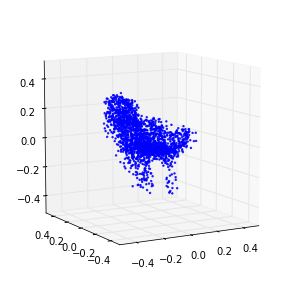

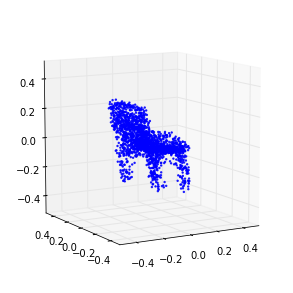

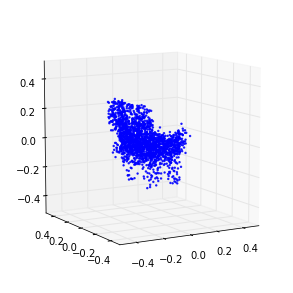

2 (-1.2324330709598683, 0.08139640663715976)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


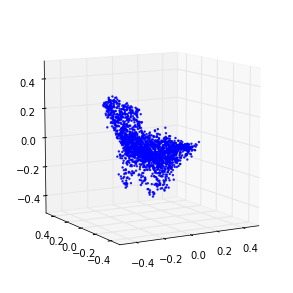

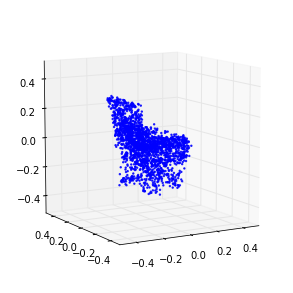

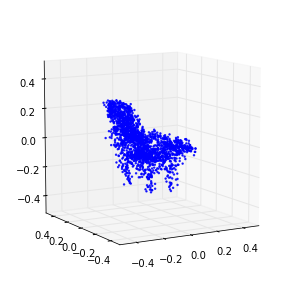

3 (-1.1716161860360039, -0.1077659648877603)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


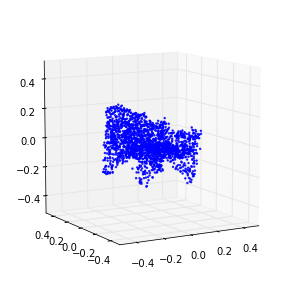

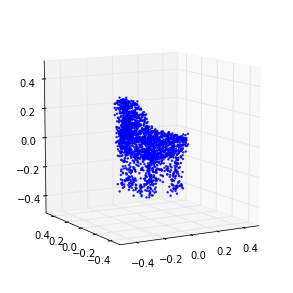

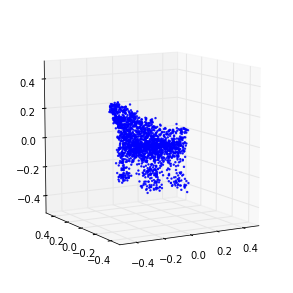

4 (-1.0627647298353691, -0.14573804509860497)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


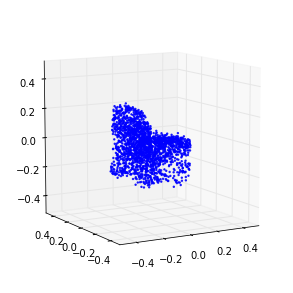

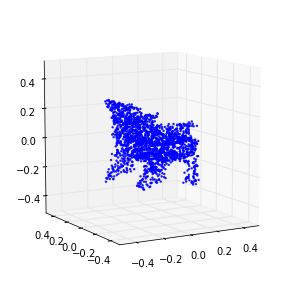

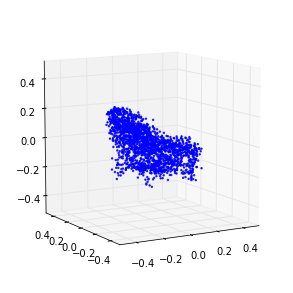

5 (-0.95314475695292156, -0.12332227605360525)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


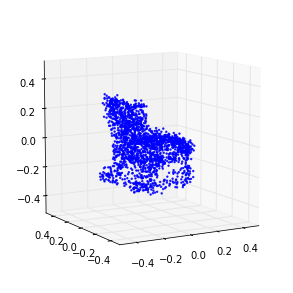

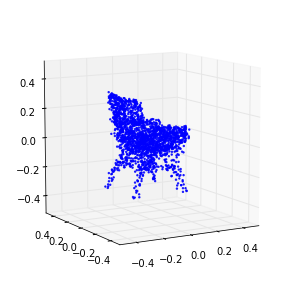

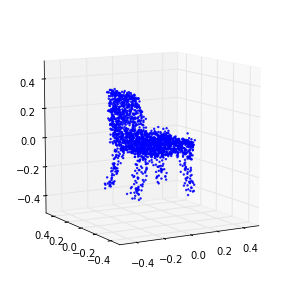

6 (-0.86909177126707859, -0.042048218435849306)
7 (-0.82137145289668334, 0.08897265922968034)
8 (-0.79224412397102073, 0.19905124273565081)
9 (-0.77975792222552831, 0.22292381525039673)
10 (-0.76730934072423862, 0.23374371230602264)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


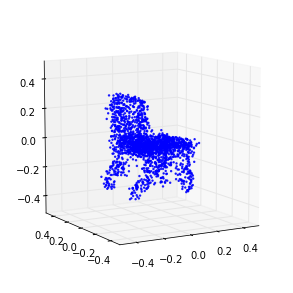

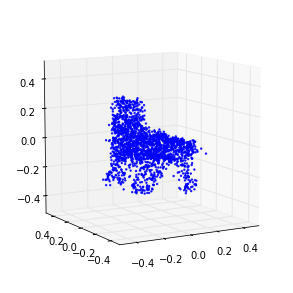

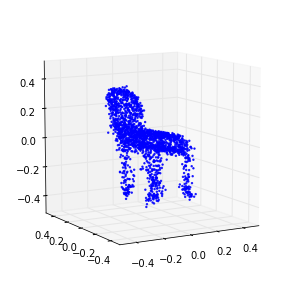

11 (-0.75449616909027095, 0.22554610228096997)
12 (-0.73812993853180497, 0.20997830231984457)
13 (-0.70983296456160372, 0.20079729292127821)
14 (-0.68703610632154677, 0.19424545047459779)
15 (-0.66061218138094302, 0.20107091632154253)
16 (-0.63170660336812334, 0.1645617769272239)
17 (-0.60532168988828305, 0.17483476356223779)
18 (-0.57206268354698464, 0.18651219126251009)
19 (-0.54146107920893916, 0.12895284758673775)
20 (-0.51290370005148433, 0.16699992451402876)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


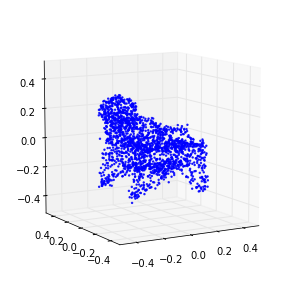

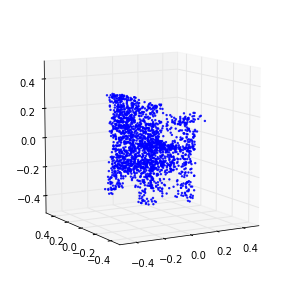

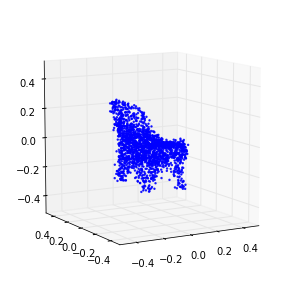

21 (-0.48958899489155522, 0.15685442641929345)
22 (-0.46098383024886802, 0.16779498811121341)
23 (-0.43593799140718248, 0.17613132491155906)
24 (-0.41725948806162233, 0.17787946319138562)
25 (-0.3954795245771055, 0.20063627318099694)
26 (-0.38030624389648438, 0.17665499503965731)
27 (-0.36291076585098547, 0.18876065355208185)
28 (-0.35001697341601051, 0.17071865112693221)
29 (-0.33343591557608709, 0.27484816257600431)
30 (-0.32529856099022758, 0.18632755566526343)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


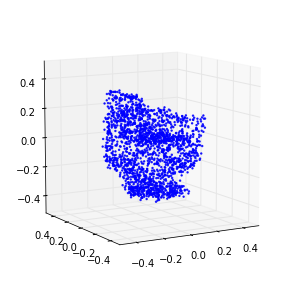

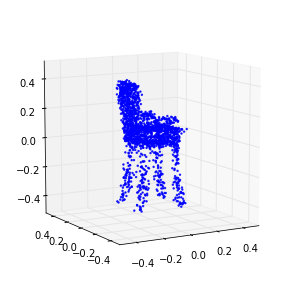

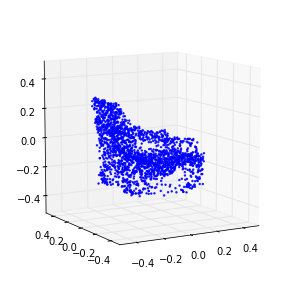

31 (-0.32058555505893849, 0.28232680757840473)
32 (-0.31030530454935851, 0.18802634764600684)
33 (-0.3064955589947877, 0.26574000053935581)
34 (-0.29904228382640413, 0.17851614524368886)
35 (-0.29806554571346, 0.26282041271527606)
36 (-0.29065467163368508, 0.22447635398970711)
37 (-0.28506995053203016, 0.20341380078483512)
38 (-0.27835764553811815, 0.22517475872128098)
39 (-0.27874355095404163, 0.23079729770068769)
40 (-0.26976171169016094, 0.19465561404272361)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


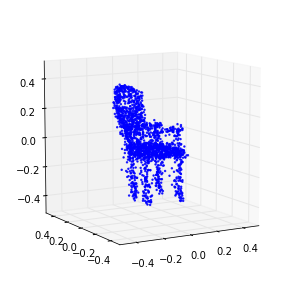

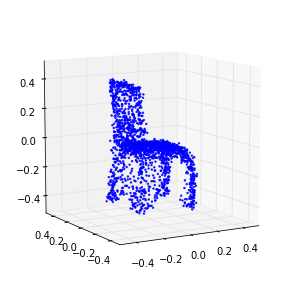

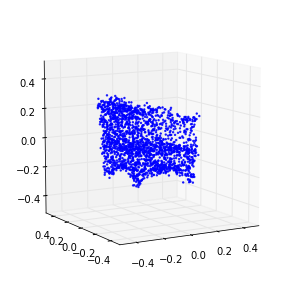

41 (-0.27034133142895167, 0.23967301790361051)
42 (-0.26896412516081775, 0.17979904457374854)
43 (-0.26408133032145326, 0.2330345548344431)
44 (-0.2616853336493174, 0.17168670120062651)
45 (-0.25631683281174411, 0.21748675681926585)
46 (-0.25590477795512589, 0.20010642321021468)
47 (-0.25327655496420681, 0.17985661038094097)
48 (-0.25202598262716225, 0.19395525284387446)
49 (-0.2477676181881516, 0.20663377642631531)
50 (-0.24689032612023531, 0.17552414757234078)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


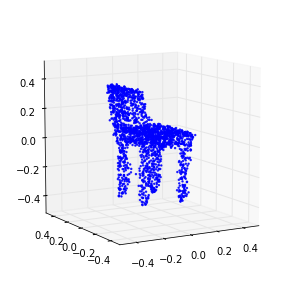

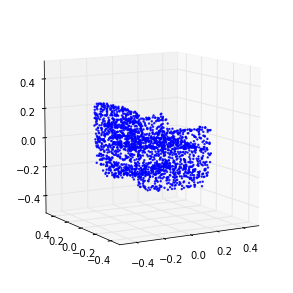

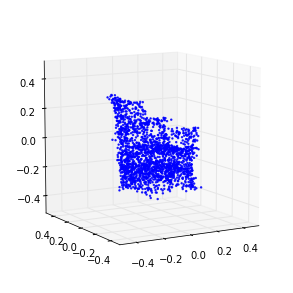

51 (-0.24096264452845961, 0.21557688657884244)
52 (-0.24227805546036474, 0.22236242228084141)
53 (-0.24035978935382984, 0.23939977089564005)
54 (-0.23403096938574755, 0.19065585594486306)
55 (-0.23277907603316836, 0.21548253021858357)
56 (-0.23117199915426748, 0.18617032799455854)
57 (-0.22173883120218912, 0.21946427612392991)
58 (-0.22566970597814631, 0.20113681836260688)
59 (-0.22639075263782785, 0.22636323394598784)
60 (-0.22274993106170937, 0.23140687743822733)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


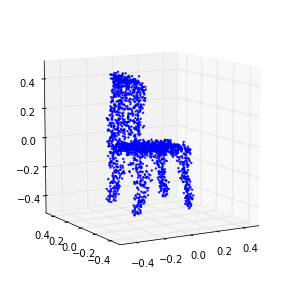

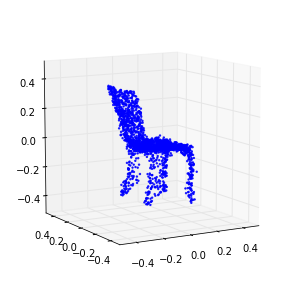

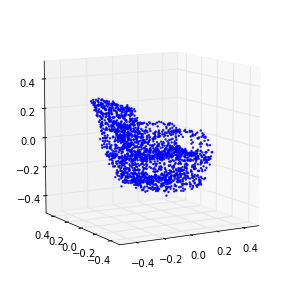

61 (-0.21722651317163749, 0.217752899284716)
62 (-0.21576831175221337, 0.23208832244078317)
63 (-0.21469851588761366, 0.21942635929142987)
64 (-0.21259112788571252, 0.22774882090312462)
65 (-0.21374257527015827, 0.22805795239077675)
66 (-0.20836962792608474, 0.24482522960062381)
67 (-0.20957448730866116, 0.23775830092253508)
68 (-0.20713473017568942, 0.25811682144800824)
69 (-0.20486847360928853, 0.24256389119006969)
70 (-0.20502086425269092, 0.2579201779983662)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


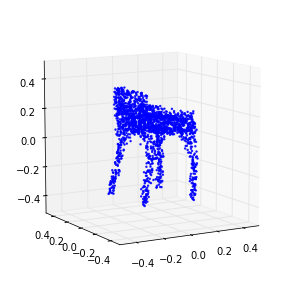

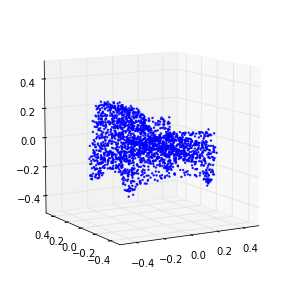

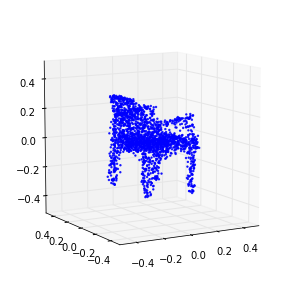

71 (-0.20381614725898814, 0.25473452773359084)
72 (-0.20400956951909596, 0.25876942001007219)
73 (-0.20628159918166972, 0.25225973239651434)
74 (-0.20208044289438812, 0.29911914743759016)
75 (-0.2045899432014536, 0.24669334126843345)
76 (-0.20186630835135777, 0.23917074501514435)
77 (-0.20218557511214857, 0.27679940285506072)
78 (-0.19961075280551557, 0.26551686558458543)
79 (-0.20200041985070263, 0.24676691823535496)
80 (-0.20105470871483838, 0.29820709868713663)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


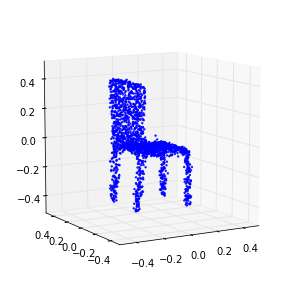

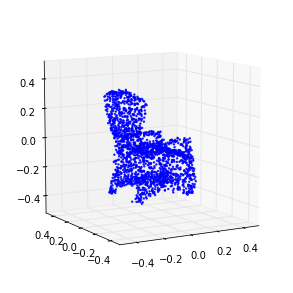

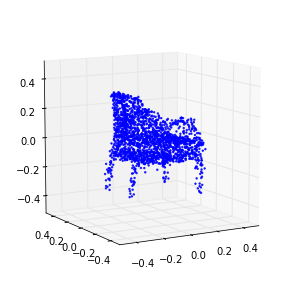

81 (-0.19839611859233292, 0.25658413491867205)
82 (-0.19792660971482595, 0.27631418131015917)
83 (-0.20016988940812924, 0.30965561999215019)
84 (-0.19702035906138243, 0.22945709802486278)
85 (-0.19576198519380003, 0.26906493747675858)
86 (-0.19425376030030073, 0.28080728705282565)
87 (-0.1978490890176208, 0.25440470267225196)
88 (-0.19254057434973892, 0.2696316496089653)
89 (-0.19562410425256799, 0.24513985437375527)
90 (-0.19409205323016201, 0.24760183140083594)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


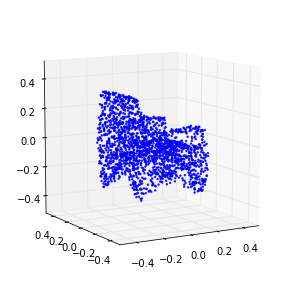

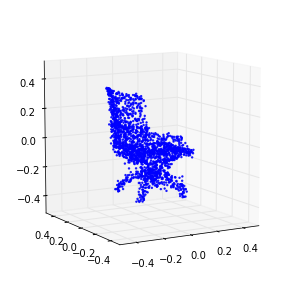

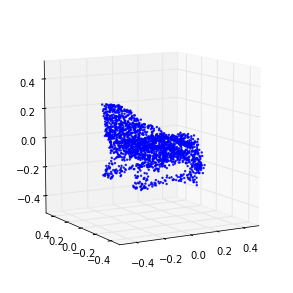

91 (-0.19250302739717343, 0.2733798341618644)
92 (-0.1937039573987325, 0.21818545957406363)
93 (-0.19430352797110875, 0.27281590192406263)
94 (-0.18988742629686992, 0.21695285594021832)
95 (-0.18943616758894039, 0.26075340641869438)
96 (-0.19140446329558336, 0.22000610938778631)
97 (-0.19258138587077459, 0.24710134775550277)
98 (-0.18910484578874376, 0.24819196926222908)
99 (-0.18879012603450704, 0.22984774355535154)
100 (-0.18584192290350243, 0.2371247057561521)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


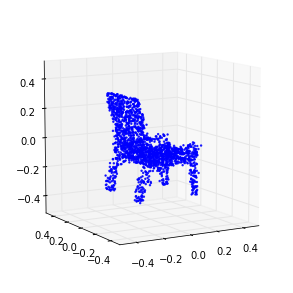

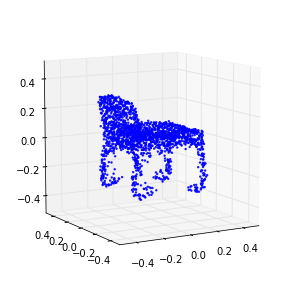

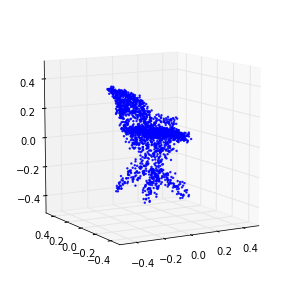

101 (-0.18569070652679162, 0.21703569535855893)
102 (-0.18564926082337344, 0.24847090078724754)
103 (-0.1876153759934284, 0.20869091042765864)
104 (-0.18386592616637548, 0.22690466708607143)
105 (-0.18685691765061133, 0.22468580084818382)
106 (-0.18694555345508787, 0.20053457192800664)
107 (-0.18793973931007915, 0.22235822236096417)
108 (-0.18707192153842361, 0.20776782488381421)
109 (-0.18683649864461688, 0.17693093888185643)
110 (-0.1845748288763894, 0.21795188663182435)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.


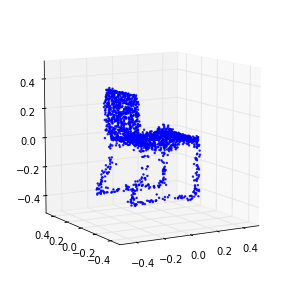

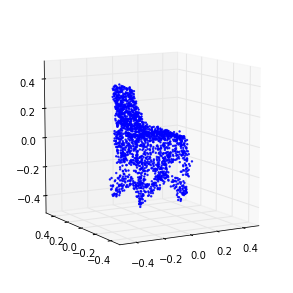

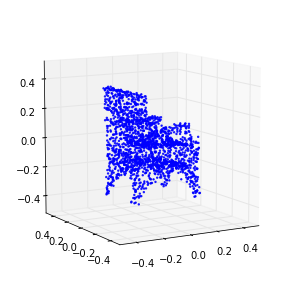

111 (-0.18542288574907514, 0.19365611175696054)
112 (-0.18277949872944091, 0.18448198393539147)
113 (-0.18647794927711839, 0.19427396136301536)
114 (-0.18376495341459911, 0.17887952206311403)
115 (-0.1875228535797861, 0.21311100323994955)
116 (-0.18517650525878976, 0.1812799526033578)
117 (-0.18679380554843833, 0.17268723856519769)
118 (-0.18402018420122288, 0.17426992952823639)
119 (-0.18630711684624354, 0.18408679437858086)
120 (-0.18448286464920752, 0.19410729518643133)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.


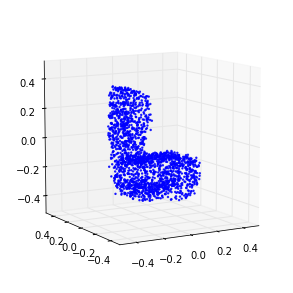

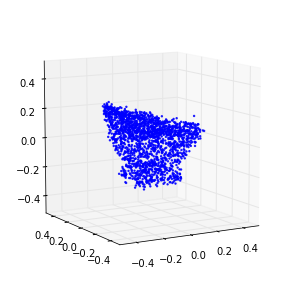

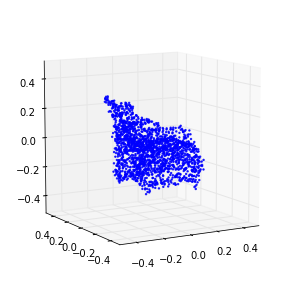

121 (-0.18440257156336748, 0.19483207828468746)
122 (-0.18952695208567161, 0.18263539451139946)
123 (-0.1876131805004897, 0.20089014702373081)
124 (-0.18666022817293804, 0.1840525018396201)
125 (-0.1850655957504555, 0.1732417016669556)
126 (-0.1861857404311498, 0.16028777482333006)
127 (-0.1845908944805463, 0.19533727511211676)
128 (-0.18617154983458695, 0.16786161258264823)
129 (-0.18769148461244725, 0.16751003044622917)
130 (-0.18401260370457614, 0.19229233182138866)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-130 is not in all_model_checkpoint_paths. Manually adding it.


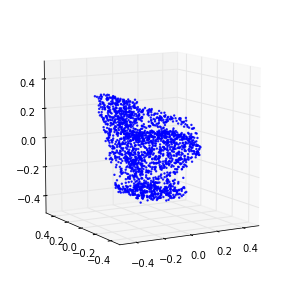

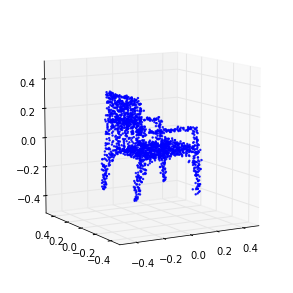

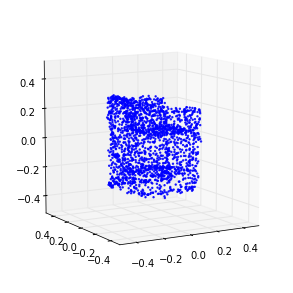

131 (-0.18508976228811122, 0.17074695284719821)
132 (-0.18685058520899878, 0.17345027570371274)
133 (-0.18439789342659491, 0.15146473891757153)
134 (-0.18403984534519691, 0.1599724048541652)
135 (-0.18269030700127284, 0.18637054606720252)
136 (-0.18591100402452326, 0.17202513168255487)
137 (-0.18362022610726181, 0.12630320450773946)
138 (-0.1830130238223959, 0.1442871027522617)
139 (-0.18447839314187015, 0.16079322552239453)
140 (-0.18374618446385418, 0.1582962634662787)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-140 is not in all_model_checkpoint_paths. Manually adding it.


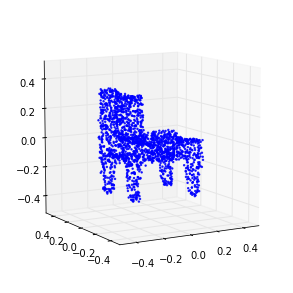

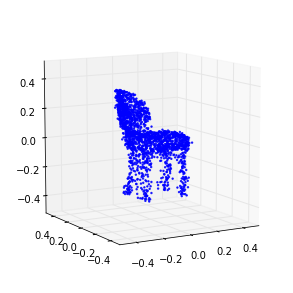

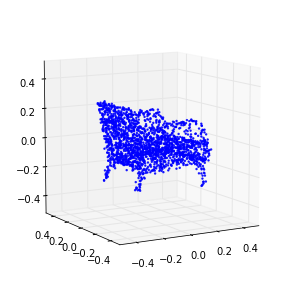

141 (-0.18404305461380216, 0.13915524079843802)
142 (-0.18751516358719933, 0.13751274154142099)
143 (-0.18273210536550594, 0.15219364811976752)
144 (-0.18126398065575847, 0.15338907170074959)
145 (-0.18428465376297634, 0.13192090047178445)
146 (-0.18539702561166552, 0.14371692389249802)
147 (-0.18081302179230585, 0.13289832158221138)
148 (-0.18125928458240298, 0.13950296105058105)
149 (-0.18566055126764155, 0.14018793459291812)
150 (-0.17955854833126067, 0.12965234755365937)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-150 is not in all_model_checkpoint_paths. Manually adding it.


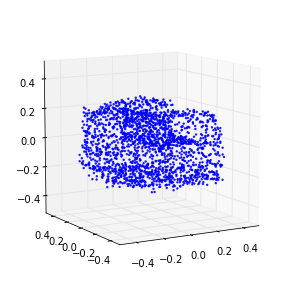

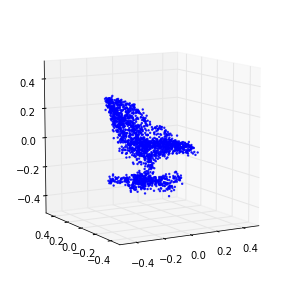

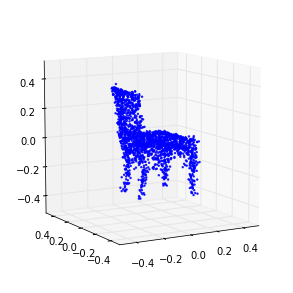

151 (-0.18438580786740338, 0.13662599358293745)
152 (-0.18454168483063027, 0.12772674196296269)
153 (-0.18110109004709457, 0.12873082414821344)
154 (-0.18185513919150387, 0.12932848433653513)
155 (-0.18215597763105676, 0.11294088319495872)
156 (-0.18571485810809665, 0.1314980582230621)
157 (-0.18575225025415421, 0.10676912618456064)
158 (-0.18073001663993907, 0.12029150335325135)
159 (-0.18398337292450445, 0.12118064074052705)
160 (-0.18194614367352591, 0.11238663616003813)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-160 is not in all_model_checkpoint_paths. Manually adding it.


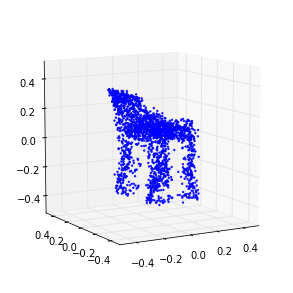

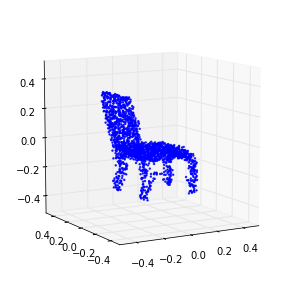

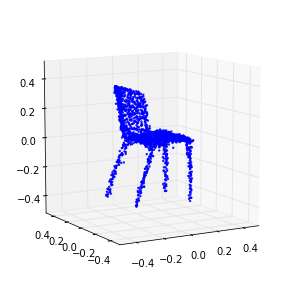

161 (-0.1824403374283402, 0.12927733644567155)
162 (-0.18156828929980595, 0.11981335999789061)
163 (-0.17953804278815233, 0.11426063437290766)
164 (-0.18234190869110603, 0.14349639415740967)
165 (-0.18132997237973744, 0.098280024887235071)
166 (-0.18111510188491256, 0.12218924170290982)
167 (-0.18235791706376606, 0.13138213808889743)
168 (-0.18114038545776295, 0.12361386694290021)
169 (-0.17807051108943092, 0.12291532727303328)
170 (-0.18177530743457654, 0.12630845371771743)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-170 is not in all_model_checkpoint_paths. Manually adding it.


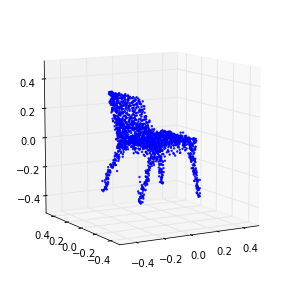

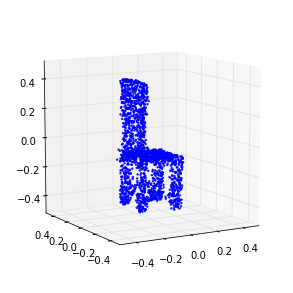

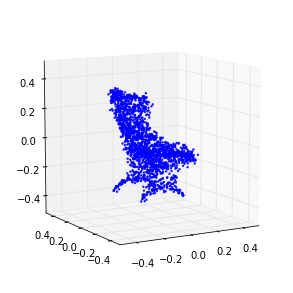

171 (-0.17901446123917897, 0.13024298170650447)
172 (-0.18309550925537391, 0.13898571028753562)
173 (-0.17988592568371031, 0.16264509464855548)
174 (-0.18017294417928767, 0.12242986813739494)
175 (-0.18245900449929414, 0.13529571338936133)
176 (-0.18284207334121069, 0.14402532853462077)
177 (-0.18150974098179076, 0.13801716378441564)
178 (-0.17915577595984494, 0.13063786482369458)
179 (-0.17810467950723791, 0.12505342659574967)
180 (-0.1828394866100064, 0.12287658553018614)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-180 is not in all_model_checkpoint_paths. Manually adding it.


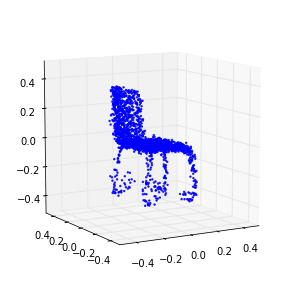

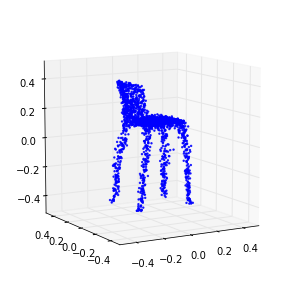

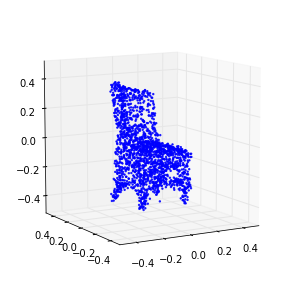

181 (-0.18036082977498019, 0.13827916510679103)
182 (-0.17834160063001844, 0.12842472601268026)
183 (-0.17906725776416285, 0.11506377602065052)
184 (-0.17770868771606022, 0.11145442986377964)
185 (-0.18034881209885634, 0.097593116815443387)
186 (-0.17976399748413652, 0.13237076749404272)
187 (-0.18068206365461703, 0.089400765796502427)
188 (-0.18025577493287898, 0.12143356049502338)
189 (-0.17909230302881313, 0.11367721924627269)
190 (-0.18166649153938999, 0.11065315331021945)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-190 is not in all_model_checkpoint_paths. Manually adding it.


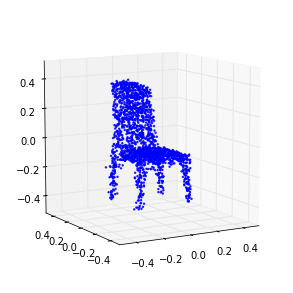

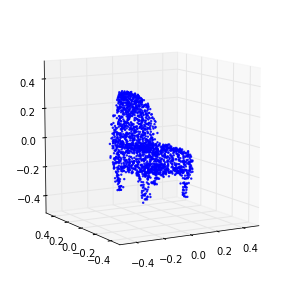

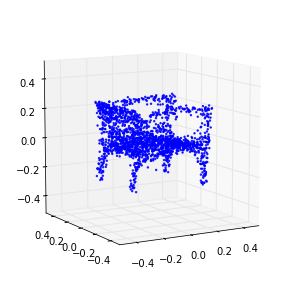

191 (-0.17970090221475671, 0.11167348838514751)
192 (-0.17772186172229273, 0.12105653021070692)
193 (-0.17725733148830908, 0.1192534761848273)
194 (-0.17973066733943091, 0.11339625357477753)
195 (-0.18031207968791327, 0.12986534861502824)
196 (-0.17847597593510592, 0.11983120027515623)
197 (-0.1768840342760086, 0.12517369290192923)
198 (-0.17931313774100058, 0.12725298368820437)
199 (-0.17972415117201981, 0.079229780938476324)
200 (-0.17811451664677372, 0.14394657465594787)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-200 is not in all_model_checkpoint_paths. Manually adding it.


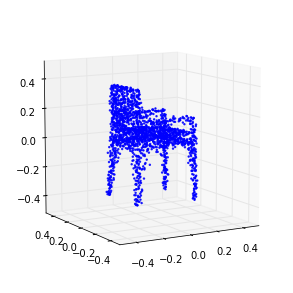

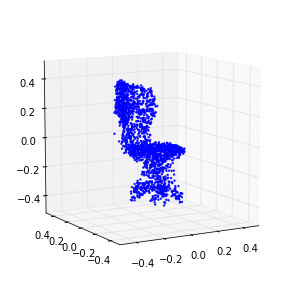

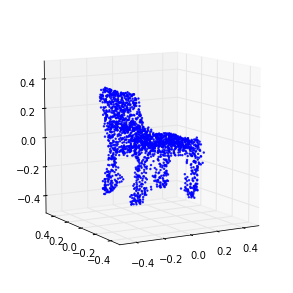

201 (-0.17828639386980621, 0.10953218241532643)
202 (-0.17913817967529649, 0.12491172690082479)
203 (-0.17696914303082006, 0.1162548244551376)
204 (-0.1804171304459925, 0.12355636915674915)
205 (-0.17915427458507044, 0.11810142822839596)
206 (-0.17430054826868904, 0.12719495428933036)
207 (-0.17644320329030355, 0.10188157111406326)
208 (-0.17539595205474784, 0.11435794168048435)
209 (-0.17559280213382508, 0.11281834211614397)
210 (-0.17458504355616039, 0.12594987700382868)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-210 is not in all_model_checkpoint_paths. Manually adding it.


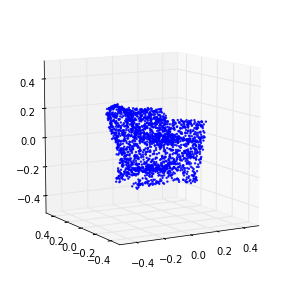

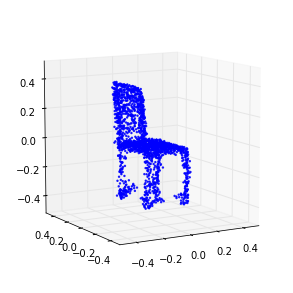

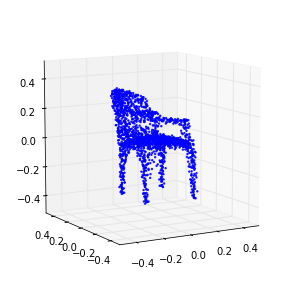

211 (-0.17685942202806473, 0.10561277744946657)
212 (-0.1763384908437729, 0.10535548130671184)
213 (-0.17470910460860642, 0.10336654798852073)
214 (-0.17491348650720384, 0.10833355812010942)
215 (-0.17322145976402142, 0.11798220831486914)
216 (-0.17339369119317444, 0.10966315796529805)
217 (-0.17547563684207421, 0.11880804570736708)
218 (-0.17403824362489911, 0.10253094730001909)
219 (-0.17237021387727172, 0.084029366952125678)
220 (-0.1732435600625144, 0.10382552893349418)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.


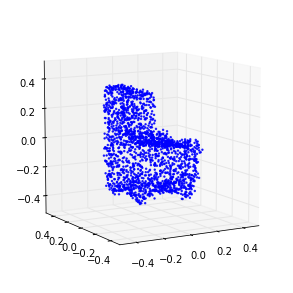

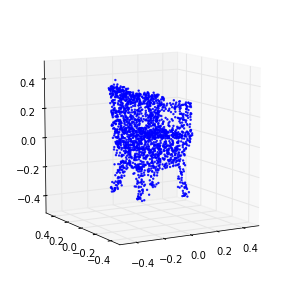

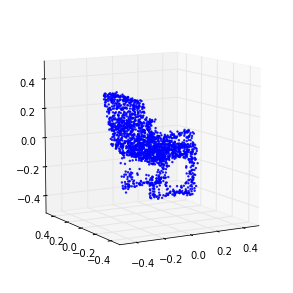

221 (-0.17427993919010515, 0.099929627548489303)
222 (-0.17437633535376301, 0.095647330223410224)
223 (-0.17416197028425004, 0.10060900228994864)
224 (-0.1716466615597407, 0.11112644206042643)
225 (-0.17364699283131846, 0.10081869970869135)
226 (-0.17194245109955469, 0.087375128227803439)
227 (-0.171589232870826, 0.089058881832493678)
228 (-0.17365900912770518, 0.093476387499659155)
229 (-0.17297261302117947, 0.090470963330180551)
230 (-0.17370317390671483, 0.092583986068213428)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-230 is not in all_model_checkpoint_paths. Manually adding it.


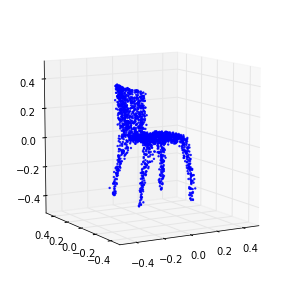

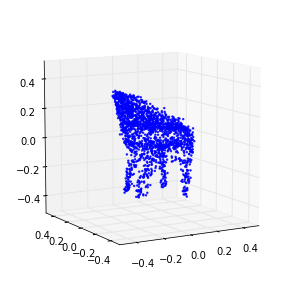

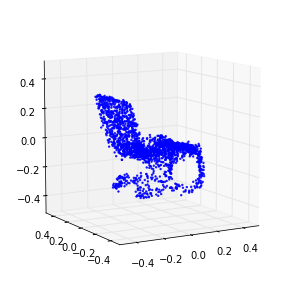

231 (-0.1715620517178818, 0.0649132051470655)
232 (-0.17839309203403966, 0.11444083311491543)
233 (-0.17377206258199834, 0.072028151609831392)
234 (-0.17377961366264907, 0.10679383118878361)
235 (-0.17406548261642457, 0.073915383950979616)
236 (-0.17671499086750878, 0.094108452537545448)
237 (-0.17326115325645164, 0.098875338832537338)
238 (-0.17294612598639947, 0.10043686528310732)
239 (-0.17355591058731079, 0.089064734194565703)
240 (-0.17143328647922587, 0.09332114927194736)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-240 is not in all_model_checkpoint_paths. Manually adding it.


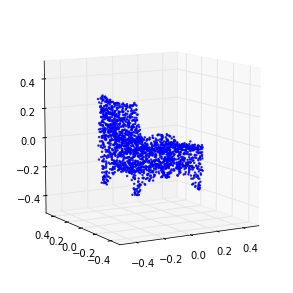

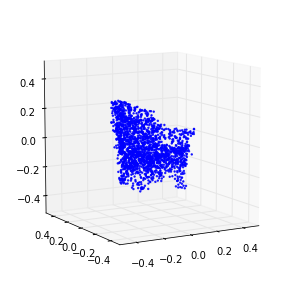

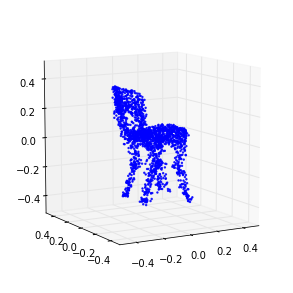

241 (-0.17253554518576023, 0.088505536179851602)
242 (-0.17421819402111902, 0.092616574907744373)
243 (-0.17292760086280329, 0.10072102328693425)
244 (-0.17211807105276319, 0.079054433300539295)
245 (-0.17362362284351279, 0.089807563771804169)
246 (-0.17271896280624249, 0.0786681894764856)
247 (-0.17032740232017304, 0.093266351769367858)
248 (-0.1662050410553261, 0.087819504517096067)
249 (-0.17295143339369032, 0.065011762703458473)
250 (-0.17331608064748621, 0.10412299715810353)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-250 is not in all_model_checkpoint_paths. Manually adding it.


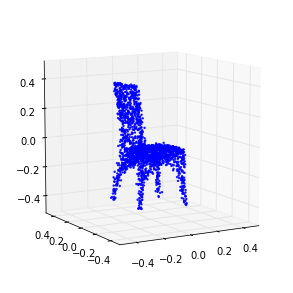

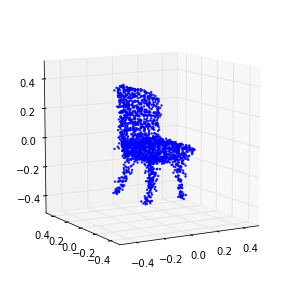

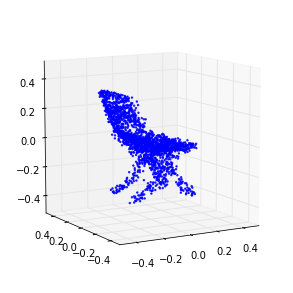

251 (-0.17057838296448743, 0.073937626900496309)
252 (-0.17088744485819782, 0.078506262352069214)
253 (-0.16917352527379989, 0.071850706995637323)
254 (-0.1679368840323554, 0.098244847384867842)
255 (-0.17067248804701698, 0.079701495322364355)
256 (-0.17134538414301695, 0.1069157508512338)
257 (-0.17035769356621636, 0.08717812514967388)
258 (-0.16749074381810647, 0.077961342271279405)
259 (-0.17000662816895379, 0.11071156924245534)
260 (-0.167380622084494, 0.078522267992849698)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-260 is not in all_model_checkpoint_paths. Manually adding it.


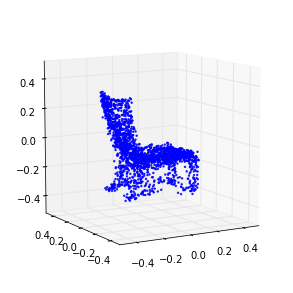

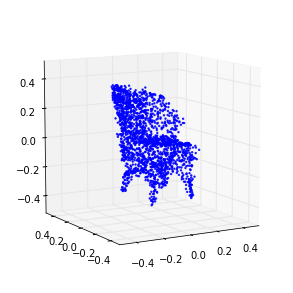

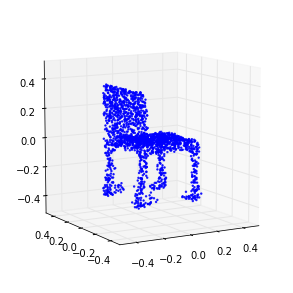

261 (-0.16996087602995061, 0.093765472441359798)
262 (-0.16905420930297285, 0.091042654381857976)
263 (-0.17043582189966131, 0.088932256662735229)
264 (-0.17028119260514224, 0.070115693327453404)
265 (-0.16948467277818255, 0.097064647685598443)
266 (-0.1680023122716833, 0.06292786214638639)
267 (-0.16887044536846654, 0.079941642850085537)
268 (-0.16874048698831487, 0.10240246203762514)
269 (-0.16762501177964387, 0.078388612786376918)
270 (-0.16902971041423304, 0.077454080805182457)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-270 is not in all_model_checkpoint_paths. Manually adding it.


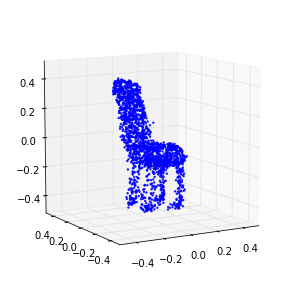

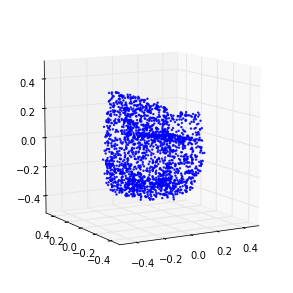

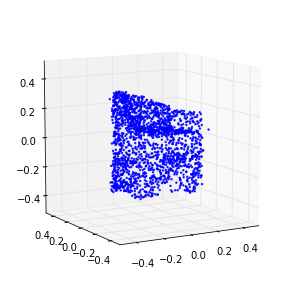

271 (-0.16617039613149784, 0.082227923734872435)
272 (-0.16725312305821313, 0.10440491319254593)
273 (-0.16793348082789669, 0.086547220332754984)
274 (-0.16724802790968507, 0.086751812034183085)
275 (-0.16719400076954452, 0.086927349782652319)
276 (-0.1695756216843923, 0.095282938055418154)
277 (-0.16611699997274965, 0.085659505109544148)
278 (-0.16844418904295674, 0.075750010502007276)
279 (-0.16945356803911704, 0.070311643735126217)
280 (-0.16402428939386651, 0.080252562822015192)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-280 is not in all_model_checkpoint_paths. Manually adding it.


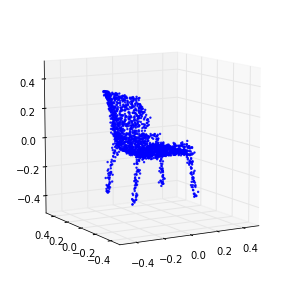

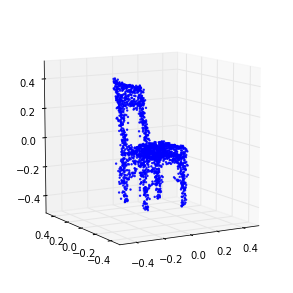

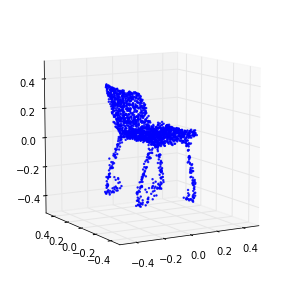

281 (-0.16643402443991767, 0.053394259746979783)
282 (-0.16688348275643808, 0.091446095870600805)
283 (-0.16730697447503054, 0.10013169505529934)
284 (-0.16513823061077684, 0.078580053385209153)
285 (-0.16633912186931682, 0.092665220576303983)
286 (-0.16711088225797371, 0.076481879447345386)
287 (-0.16861614800161787, 0.089067085197678322)
288 (-0.16885924775291372, 0.090611461274049898)
289 (-0.16612612958307618, 0.08606775146391657)
290 (-0.16312744678170593, 0.070625334426208775)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-290 is not in all_model_checkpoint_paths. Manually adding it.


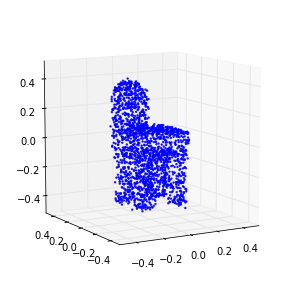

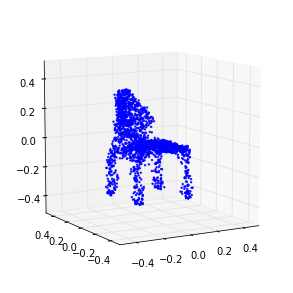

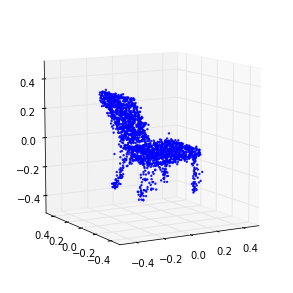

291 (-0.1669718035945186, 0.084963050429467807)
292 (-0.16311133702596028, 0.092425696413826058)
293 (-0.16948040541675355, 0.088737968493390967)
294 (-0.16540057140368003, 0.08316805282676662)
295 (-0.16729088999606945, 0.086900364814533129)
296 (-0.16402208802324755, 0.092495072495054315)
297 (-0.16402815183003744, 0.096298959520128041)
298 (-0.16394790720056604, 0.095126643500946184)
299 (-0.16717823727263345, 0.074482413767664526)
300 (-0.16641297815022646, 0.086034750358925924)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-300 is not in all_model_checkpoint_paths. Manually adding it.


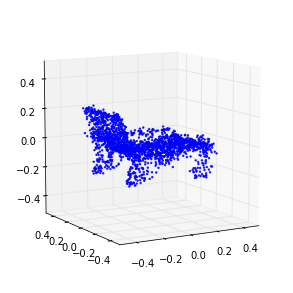

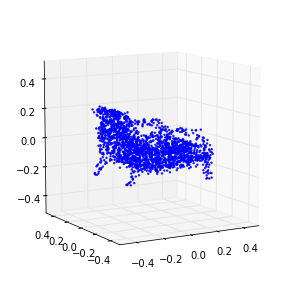

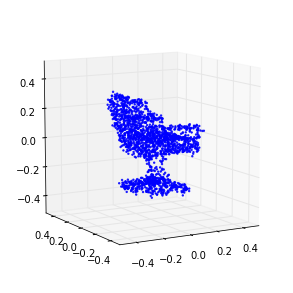

301 (-0.16610503842433294, 0.076388842150293013)
302 (-0.1639065228678562, 0.07711716893094557)
303 (-0.16697489530951889, 0.07738014324395745)
304 (-0.16692953142854902, 0.094021697839101151)
305 (-0.16514847118545462, 0.079151184815499515)
306 (-0.16633034712738462, 0.078541399014216876)
307 (-0.16414829492568969, 0.083563406020402908)
308 (-0.16477059661238283, 0.080027281341177439)
309 (-0.1683397881962635, 0.065224986109468669)
310 (-0.16550783432192273, 0.093722366624408304)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-310 is not in all_model_checkpoint_paths. Manually adding it.


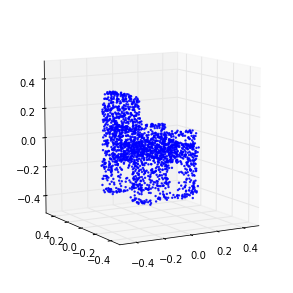

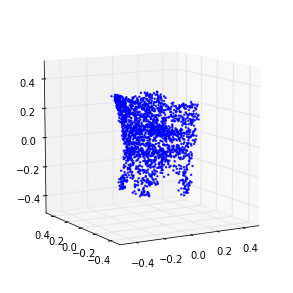

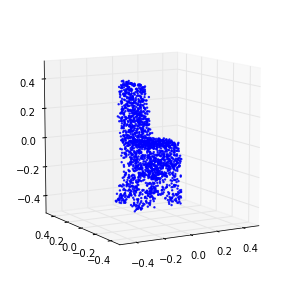

311 (-0.16488748810909412, 0.070137908958174566)
312 (-0.16334511659763479, 0.087675587722548728)
313 (-0.16425388157367707, 0.069921824391241422)
314 (-0.16607566735258808, 0.078651531289021179)
315 (-0.16275258130497403, 0.10133658584069323)
316 (-0.16559716021573101, 0.082274857770513604)
317 (-0.1629581034735397, 0.088209766756605218)
318 (-0.16782123827271991, 0.099104689365183865)
319 (-0.16626723673608568, 0.089693368585021402)
320 (-0.16229871296220355, 0.07221087489139151)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-320 is not in all_model_checkpoint_paths. Manually adding it.


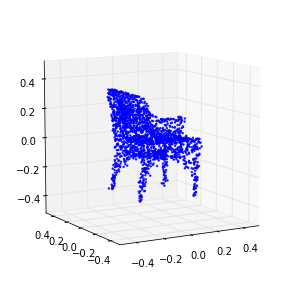

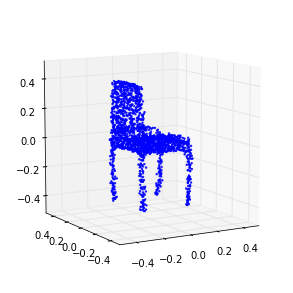

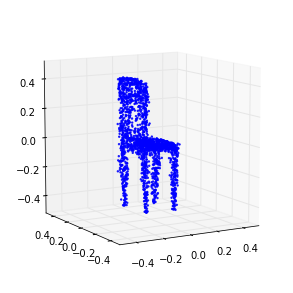

321 (-0.16328987070807705, 0.08994305437361752)
322 (-0.16810883233944576, 0.087111096001333654)
323 (-0.16388059010108311, 0.0829829362531503)
324 (-0.15897851266242841, 0.090439817419758553)
325 (-0.16184723393784628, 0.086604971300672601)
326 (-0.16228756496199856, 0.089410534335507288)
327 (-0.16574802034431033, 0.09111200935310787)
328 (-0.16495593372318479, 0.10627281610612516)
329 (-0.16355763022546416, 0.089467457599110067)
330 (-0.161993032362726, 0.096096255368104691)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-330 is not in all_model_checkpoint_paths. Manually adding it.


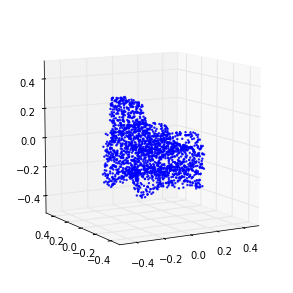

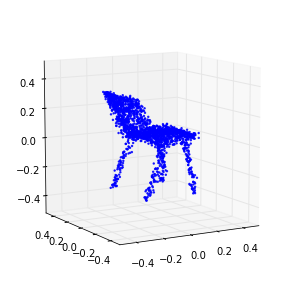

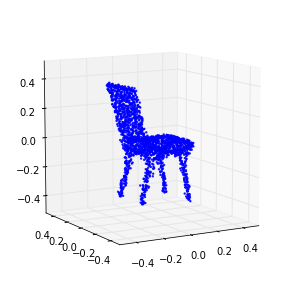

331 (-0.16543815709926463, 0.095635329407674288)
332 (-0.16104639994877357, 0.089123301070045541)
333 (-0.16556569128124801, 0.096868118892113372)
334 (-0.16371991137663525, 0.089412035627497569)
335 (-0.16337415874004363, 0.089385486587330143)
336 (-0.16416965480203982, 0.079762970545777565)
337 (-0.15991000974619829, 0.093522648706480305)
338 (-0.16084080619944466, 0.1069671601333)
339 (-0.16292977393777283, 0.099249740579613929)
340 (-0.16100658112102084, 0.090740410955967729)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-340 is not in all_model_checkpoint_paths. Manually adding it.


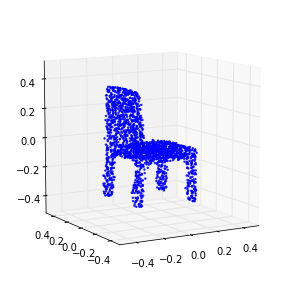

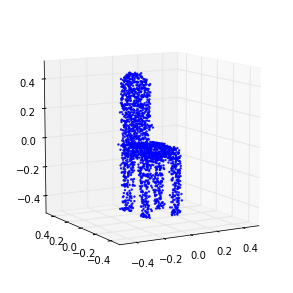

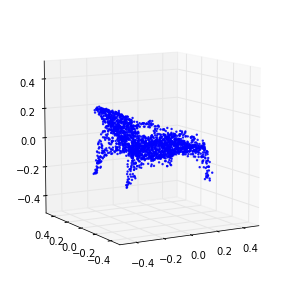

341 (-0.16585000874819578, 0.091176229908510487)
342 (-0.16435580512991657, 0.10575690810327176)
343 (-0.16373921605171982, 0.084440971621208727)
344 (-0.16391178612355833, 0.10258147699965371)
345 (-0.16014301793442831, 0.11081377320267537)
346 (-0.16016756439650501, 0.11679560166818125)
347 (-0.16126399597635976, 0.10638182389515417)
348 (-0.15926235069831213, 0.10084741755768105)
349 (-0.16277177852612953, 0.12802112681998146)
350 (-0.16040551916316703, 0.10697889907492532)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.


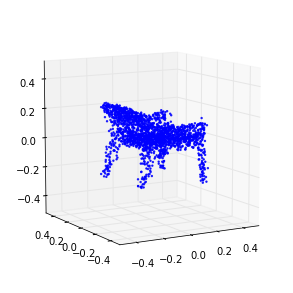

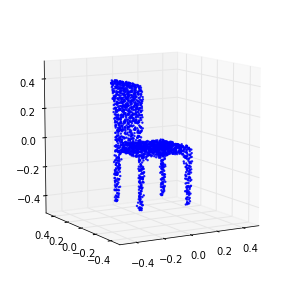

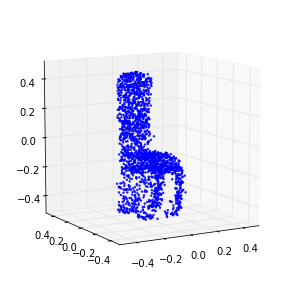

351 (-0.16137426710791059, 0.10504547906694589)
352 (-0.16316426512267854, 0.10921924450883159)
353 (-0.16170286354091432, 0.10475005940706641)
354 (-0.16223575406604343, 0.11511232662532064)
355 (-0.16168767511844634, 0.088262160067205081)
356 (-0.15900998562574387, 0.10604802298325079)
357 (-0.16019262500383236, 0.10573243929280175)
358 (-0.16371753425509841, 0.10830273479223251)
359 (-0.16082325053435784, 0.11638317174381679)
360 (-0.15967832163528159, 0.11436537184097149)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-360 is not in all_model_checkpoint_paths. Manually adding it.


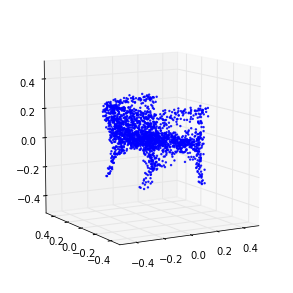

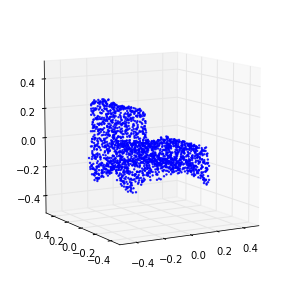

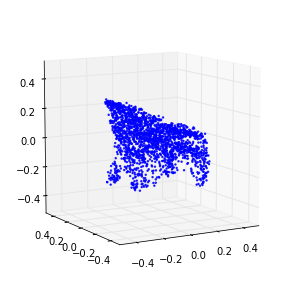

361 (-0.1641716358838258, 0.11136812026853915)
362 (-0.16375901892229364, 0.12043190526741522)
363 (-0.16150279994364139, 0.1237837928864691)
364 (-0.16286323732799954, 0.11686738635654803)
365 (-0.15859804920576237, 0.11013901716581097)
366 (-0.16235814646438315, 0.10014742640433488)
367 (-0.16370533478480798, 0.11896800553357159)
368 (-0.15895679284025122, 0.11823845820294486)
369 (-0.15897094783959564, 0.12183227665998318)
370 (-0.15837487666695207, 0.12129586410743219)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-370 is not in all_model_checkpoint_paths. Manually adding it.


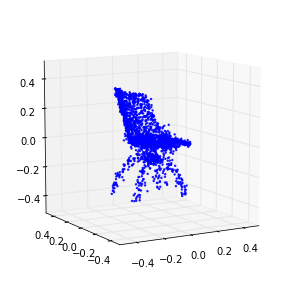

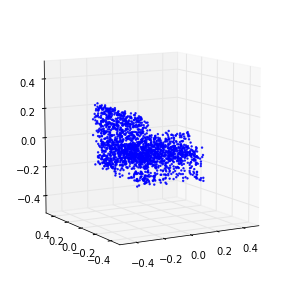

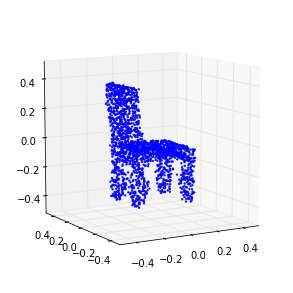

371 (-0.16195492358119398, 0.11329678722001889)
372 (-0.15894755550004819, 0.11393685307767656)
373 (-0.1613751639370565, 0.10160234653287464)
374 (-0.1575593016213841, 0.10550255356011567)
375 (-0.16127212555320175, 0.11194874401445742)
376 (-0.16145748324968195, 0.1203187174267239)
377 (-0.1600832243208532, 0.12013821828144568)
378 (-0.15886170422589338, 0.09885692527448689)
379 (-0.16355279584725699, 0.12154604080650541)
380 (-0.15995963447623782, 0.1287083832754029)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-380 is not in all_model_checkpoint_paths. Manually adding it.


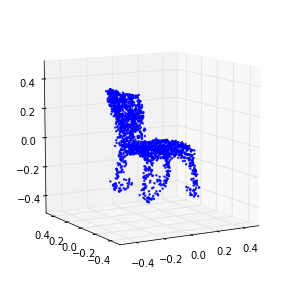

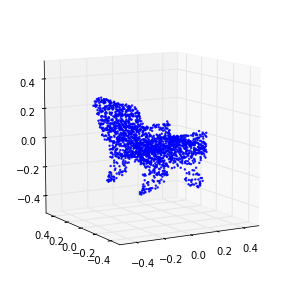

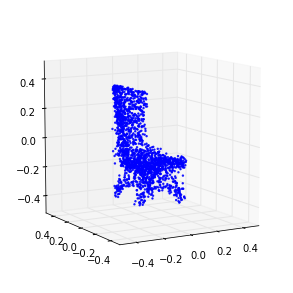

381 (-0.15957369738154942, 0.12061045236057705)
382 (-0.16341575433810551, 0.11827197229420697)
383 (-0.16144983608413627, 0.10762521734944096)
384 (-0.16077145271831089, 0.12679451400483097)
385 (-0.15852787958251105, 0.11261861550587195)
386 (-0.15910260655261851, 0.13905901158297504)
387 (-0.16136110176642735, 0.11739779981198134)
388 (-0.1626721982050825, 0.1211741500430637)
389 (-0.15796911517779033, 0.1182893227647852)
390 (-0.16041912927671714, 0.1204511081730878)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-390 is not in all_model_checkpoint_paths. Manually adding it.


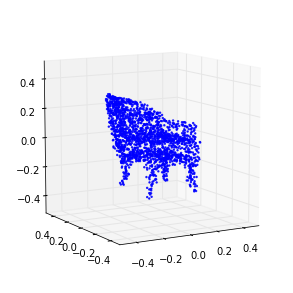

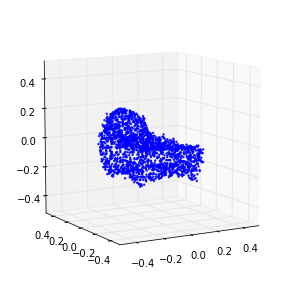

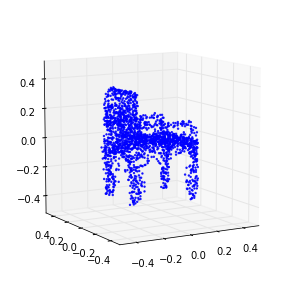

391 (-0.15828163176774979, 0.10176455146736568)
392 (-0.15855384877434484, 0.11425359795490901)
393 (-0.15925390819708507, 0.11607908871438768)
394 (-0.15857209187966806, 0.12232477024749473)
395 (-0.16191394903041698, 0.1329598421299899)
396 (-0.1587651472400736, 0.11639465143283208)
397 (-0.16127598180815025, 0.12264104849762386)
398 (-0.1598408556094876, 0.11185692112754893)
399 (-0.15809744083219104, 0.10278808077176411)
400 (-0.15977633711364533, 0.11772935258017646)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-400 is not in all_model_checkpoint_paths. Manually adding it.


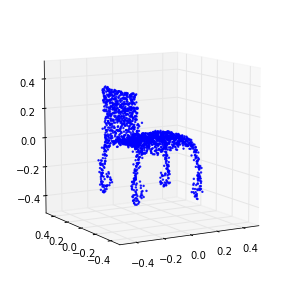

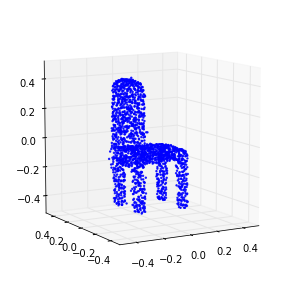

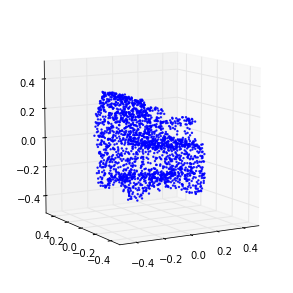

401 (-0.16157209194368785, 0.11005345069699818)
402 (-0.1590661577604435, 0.12006513939963447)
403 (-0.15672377679083083, 0.10671215683773712)
404 (-0.15720996393097772, 0.10883997491112461)
405 (-0.15543885341397037, 0.12137957579559749)
406 (-0.16087807466586432, 0.12384627856038234)
407 (-0.15894105467531416, 0.11256197398459469)
408 (-0.15697016451093887, 0.11728446157994094)
409 (-0.16175947686036427, 0.11901693515203617)
410 (-0.15727362158121885, 0.12339712596601909)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-410 is not in all_model_checkpoint_paths. Manually adding it.


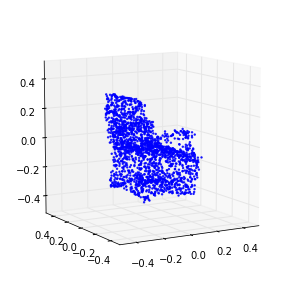

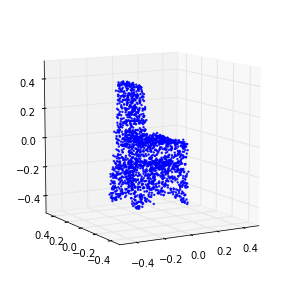

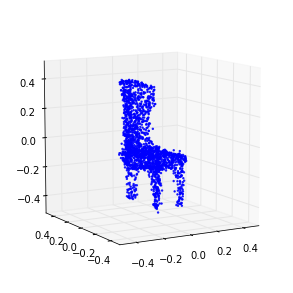

411 (-0.16008191666117422, 0.12871190105323438)
412 (-0.15791852319682087, 0.10565194004663715)
413 (-0.15755189408858616, 0.1156417625369849)
414 (-0.15828265106236494, 0.11797043984686886)
415 (-0.15930697846191902, 0.1124418940809038)
416 (-0.15712919329051619, 0.10782715733404513)
417 (-0.16044568700922859, 0.12343648186436405)
418 (-0.15823030725673393, 0.12051925145917469)
419 (-0.15754489164661478, 0.13082623840482147)
420 (-0.15940527888359846, 0.12325834952018878)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-420 is not in all_model_checkpoint_paths. Manually adding it.


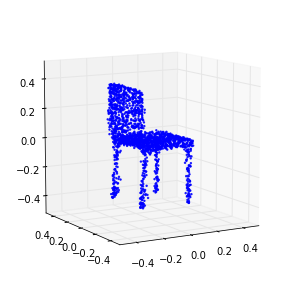

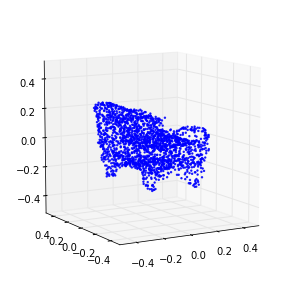

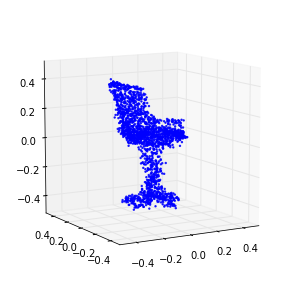

421 (-0.16050313678052691, 0.10879881707606492)
422 (-0.15902089758051766, 0.12700219259217935)
423 (-0.15789788299136692, 0.12920210565681811)
424 (-0.15887147855979425, 0.11723001356478091)
425 (-0.15430411801294044, 0.11947125831135998)
426 (-0.15933456227735238, 0.12197713333147543)
427 (-0.1608898584489469, 0.1216137698955006)
428 (-0.15711892467957955, 0.11940926120237068)
429 (-0.15958909486178999, 0.1233089483446545)
430 (-0.1600799263075546, 0.10312328349660944)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-430 is not in all_model_checkpoint_paths. Manually adding it.


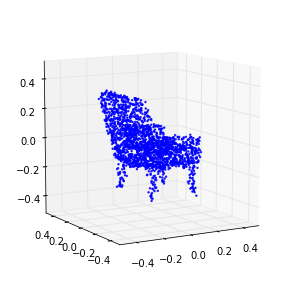

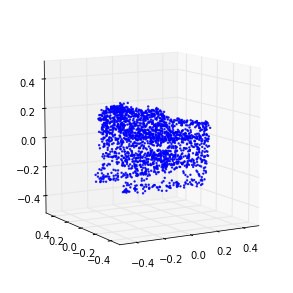

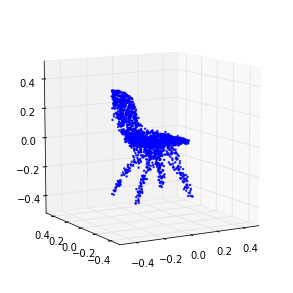

431 (-0.15726965842423615, 0.11051596342413514)
432 (-0.15721006249939953, 0.11144735112234398)
433 (-0.15817658272054461, 0.12183325461767337)
434 (-0.15711330053982911, 0.11565746615330379)
435 (-0.1590910291230237, 0.12494254029459423)
436 (-0.15786476565731897, 0.10984907809782911)
437 (-0.15685837798648411, 0.11384974033744247)
438 (-0.15897380698610236, 0.12661332278339951)
439 (-0.15937703218724991, 0.12086471611702884)
440 (-0.15796937749341683, 0.11027801036834717)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-440 is not in all_model_checkpoint_paths. Manually adding it.


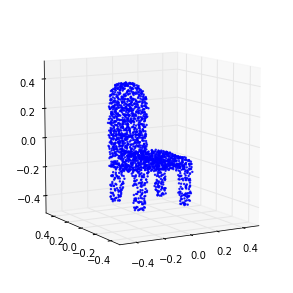

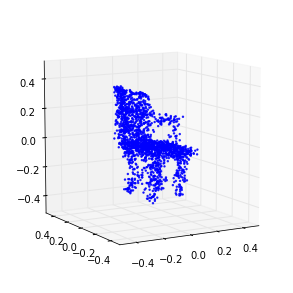

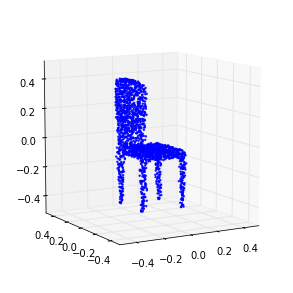

441 (-0.15781585590706931, 0.11197951491232272)
442 (-0.15744555046161016, 0.11086193085820586)
443 (-0.15951194476198266, 0.12244885000917646)
444 (-0.15502246712093001, 0.10571647076695054)
445 (-0.15550500005483628, 0.10870520798144517)
446 (-0.16139870859958508, 0.11232820760320734)
447 (-0.15658238899928553, 0.11036444703737895)
448 (-0.15842675081005803, 0.12566822656878718)
449 (-0.15850658251179589, 0.12232437950593454)
450 (-0.15919422148554413, 0.11326404688534913)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-450 is not in all_model_checkpoint_paths. Manually adding it.


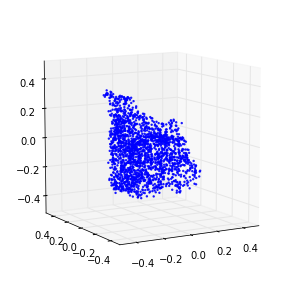

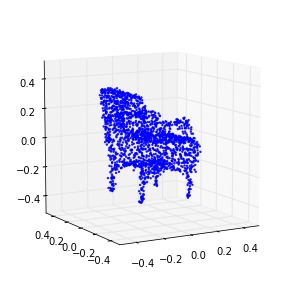

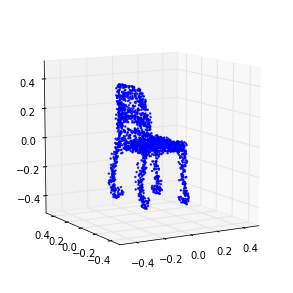

451 (-0.15677215230685693, 0.12599229012374524)
452 (-0.1581788530504262, 0.11726092878315184)
453 (-0.15874776133784541, 0.12536175217893389)
454 (-0.1595786088042789, 0.13040651587976348)
455 (-0.15784108412486536, 0.11327841712368859)
456 (-0.15607690623512974, 0.12165723106375446)
457 (-0.1554329757337217, 0.12317372417008435)
458 (-0.15983634066802485, 0.12293397028137136)
459 (-0.15667715067112886, 0.1314481242939278)
460 (-0.1539576953208005, 0.12138857471722143)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-460 is not in all_model_checkpoint_paths. Manually adding it.


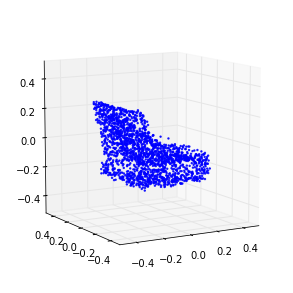

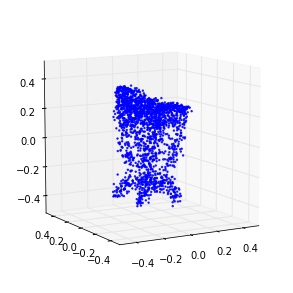

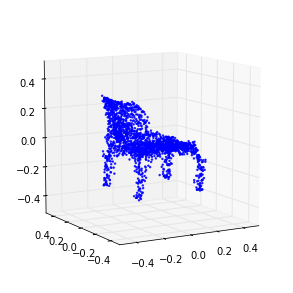

461 (-0.1557488853732745, 0.13053383926550546)
462 (-0.15567428624188459, 0.11440755426883698)
463 (-0.15407227023884101, 0.12205950281134358)
464 (-0.15751859198013943, 0.126620350336587)
465 (-0.1559091298116578, 0.111860197727327)
466 (-0.15568823604672044, 0.1085930770194089)
467 (-0.154180690922119, 0.12838634683026207)
468 (-0.15731941461563109, 0.11972499528416881)
469 (-0.15496882283025318, 0.1119312020363631)
470 (-0.15302380097133142, 0.11006395822321927)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-470 is not in all_model_checkpoint_paths. Manually adding it.


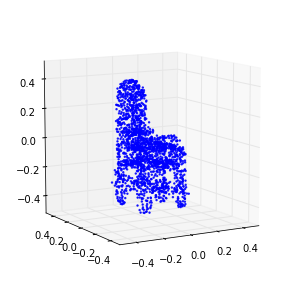

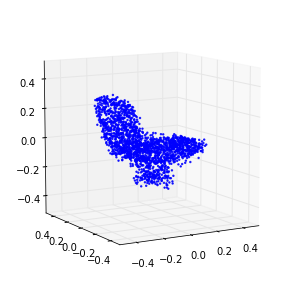

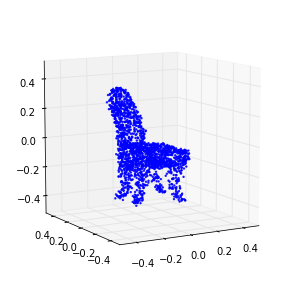

471 (-0.15612596637672849, 0.11756539234408626)
472 (-0.15349204921060139, 0.13149432948342077)
473 (-0.15650848779413434, 0.11608176292092712)
474 (-0.1537862225815102, 0.12783693825757061)
475 (-0.15325684426007447, 0.11700002711128306)
476 (-0.15411177972952525, 0.12536473599848924)
477 (-0.15486658844682905, 0.11830047807759708)
478 (-0.15422011939463792, 0.11190795677679556)
479 (-0.1564873383001045, 0.11554425816845011)
480 (-0.1560854553072541, 0.12583629124694401)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-480 is not in all_model_checkpoint_paths. Manually adding it.


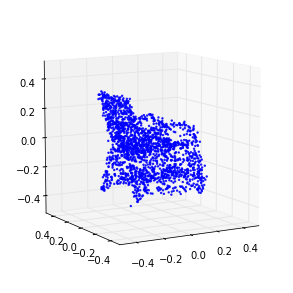

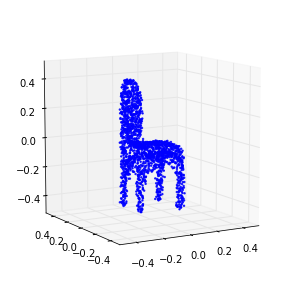

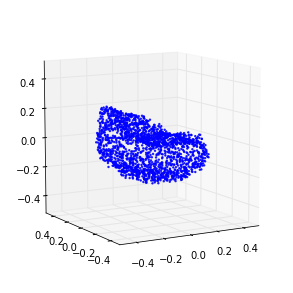

481 (-0.15601420518424775, 0.12497552843005569)
482 (-0.15286042061116961, 0.1267754551437166)
483 (-0.15434205377543414, 0.11749157005989994)
484 (-0.15427598539325926, 0.1216516442320965)
485 (-0.156303142507871, 0.12911122292280197)
486 (-0.15456172470693236, 0.12941314749143742)
487 (-0.15406106489676016, 0.12309984255720068)
488 (-0.1561610734573117, 0.12579626576216132)
489 (-0.15400392104078223, 0.11661206848091549)
490 (-0.15242004502150747, 0.12064947408658487)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-490 is not in all_model_checkpoint_paths. Manually adding it.


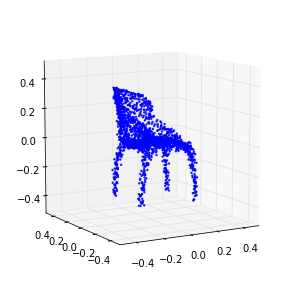

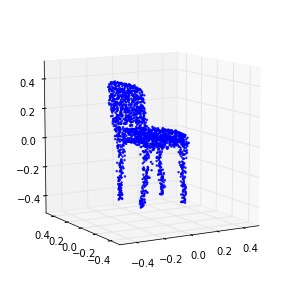

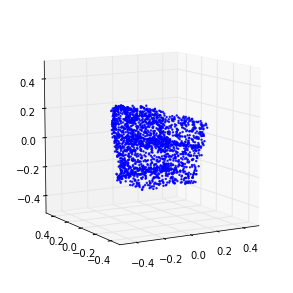

491 (-0.15385785202185312, 0.11732074535555309)
492 (-0.1566393044811708, 0.11847539549624478)
493 (-0.15372307201226551, 0.12204331242375904)
494 (-0.15537163063331885, 0.12983611336460821)
495 (-0.15553907081484794, 0.12188238347018207)
496 (-0.15507675646631805, 0.12611116689664345)
497 (-0.15263622485929065, 0.12829873103786399)
498 (-0.15523582807293645, 0.12088385748642462)
499 (-0.15307379287702066, 0.13396108729971778)
500 (-0.15499041372979128, 0.13197667262068502)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/test_nb_wgan_gp_ae_11_emd_chair_2048_best_epoch_epoch/models.ckpt-500 is not in all_model_checkpoint_paths. Manually adding it.


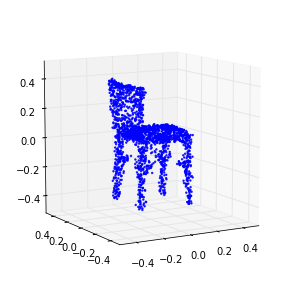

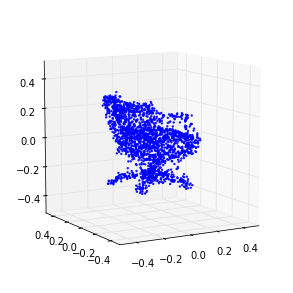

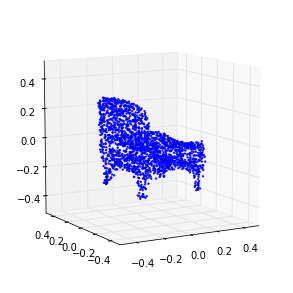

In [10]:
save_dir = osp.join(synthetic_data_out_dir, experiment_name)
save_dir = create_dir(save_dir)

buf_size = 1 # flush each line
if do_training:    
    train_stats = []
    log_file = open(osp.join(train_dir, 'train_stats.txt'), 'a', buf_size)
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss                
        log_file.write('%04d\t%.9f\t%.9f\t%.4f\n' % (epoch, loss[0], loss[1], duration / 60.0))        

        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(save_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot(in_u_sphere=True)
                        
        train_stats.append((epoch,) + loss)
    log_file.close()

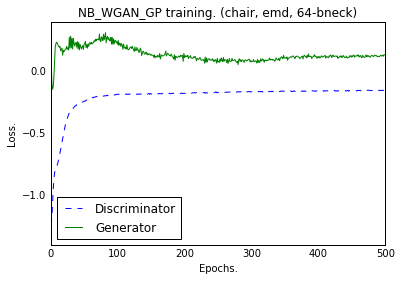

In [11]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('NB_WGAN_GP training. (%s, %s, %s-bneck)' %(class_name, ae_loss, ae.bottleneck_size))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')
    
    plt.savefig(osp.join(train_dir, 'training_curve.png'))